# Source Code Notebook - InceptionV3


## Image Conversion and Validation


### Conversion of JPG to JPEG

```
pip install opencv-python
```


In [141]:
import cv2
import os
from pathlib import Path
DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# def jpg_to_jpeg(data_dir):
#     for dir_name in os.listdir(data_dir):
#         if (dir_name != '.DS_Store'):
#             files = os.path.join(data_dir,dir_name)
#             for filepaths in os.listdir(files):
#                 file_names = os.path.join(files,filepaths)
#                 if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
#                     img = cv2.imread(str(file_names))
#                     cv2.imwrite(file_names[0:-4]+".jpeg", img)
#                     os.remove(file_names)
                    
# jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/AI Art")
# jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/Real")

### Checking of the validity of Images in the dataset


In [142]:
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

### Convert all PNG colorspaces to RGB


In [143]:
# from PIL import Image
# def fix_colorspace(data_dir):
#     for dir_name in os.listdir(data_dir):
#         if (dir_name != '.DS_Store'):
#             files = os.path.join(data_dir, dir_name)
#             for filepaths in os.listdir(files):
#                 file_names = os.path.join(files, filepaths)
#                 img = Image.open(file_names)
#                 # print(img.info)
#                 if 'icc_profile' in img.info:
#                     del img.info['icc_profile']
#                     img.save(file_names)
#                 if img.mode != 'RGB':   
#                     img = img.convert('RGB')
#                     img.save(file_names)
    
# fix_colorspace(data_dir="dataset/AI Art vs Real Art/AI Art")
# fix_colorspace(data_dir="dataset/AI Art vs Real Art/Real")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [144]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
Python Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
Tensorflow version: 2.16.1
Keras version: 3.2.1

GPU is available


### Set constants for Images


In [145]:
BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

### Use Keras' Preprocessing modules to split data


In [146]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
    verbose=True,
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
    verbose=True,
)

# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


### Display Sample Images


/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_70998/1496282019.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])
2024-05-16 22:27:07.716303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


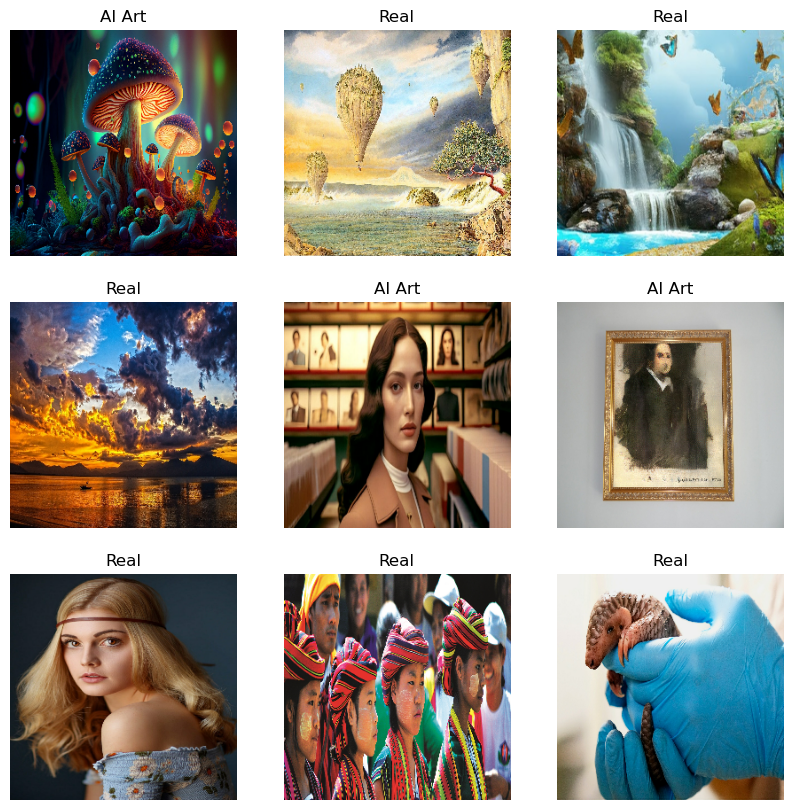

In [147]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")
display_binary_images(train_dataset, class_names)

In [148]:
rescale = keras.layers.Rescaling(1./255)

# Apply the rescaling to the datasets
train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

## Importing InceptionV3


### Import InceptionV3 as our base model


In [149]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    input_shape=(HEIGHT, WIDTH, 3),
)

### Make base model non-trainable


In [150]:
base_model.trainable = False

## Fine-Tuning the model


### Create new Model on Top


In [151]:
from keras import layers
# Starting layers
inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
x = base_model(inputs, training=False) # run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [152]:
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

## Training the Model


### Util Methods


In [153]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 8
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) 
        / epochs_drop))
    return lr

In [154]:
EPOCHS = 50
stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, 
    monitor="val_loss", 
    start_from_epoch=15, 
    verbose=1)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

fine_tuned_model = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,  
)

Epoch 1/50


12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - binary_accuracy: 0.5012 - loss: 0.8163 - val_binary_accuracy: 0.5495 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 929ms/step - binary_accuracy: 0.6082 - loss: 0.6712 - val_binary_accuracy: 0.5604 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 835ms/step - binary_accuracy: 0.6419 - loss: 0.6181 - val_binary_accuracy: 0.6923 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 820ms/step - binary_accuracy: 0.7302 - loss: 0.5581 - val_binary_accuracy: 0.7802 - val_loss: 0.5372 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 794ms/step - binary_accuracy: 0.7584 - loss: 0.5241 - val_binary_accuracy: 0.7033 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 797ms/step - binary_accuracy: 0.7779 - loss: 0.5068 - val_binary_accuracy: 0.7582 - val_loss: 0.5035 - learning_rate: 0.0010
Epoch 7/50
1

## Evaluation of the Model


### Predicting a Specific Image


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Predictions: [1.]
The predicted class for the image dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg is: Real Art


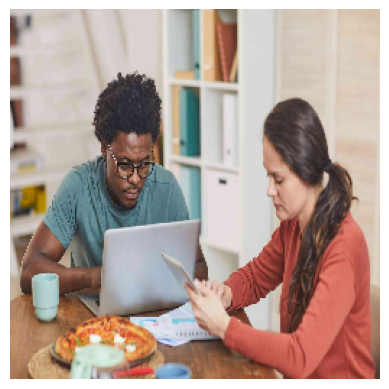

In [155]:
img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {img_path} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


dataset/AI Art vs Real Art/AI Art/AiArtData
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predictions: [0.00104722]
The predicted class for the image 188PNRFVDD0f9aTkdz34WYA.png is: AI Art


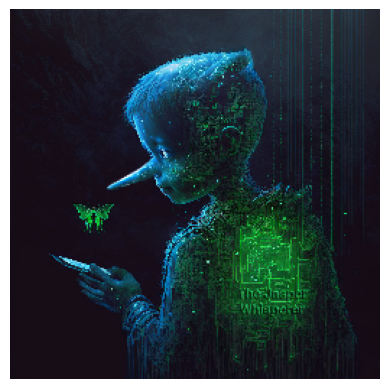

In [156]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {random_file} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


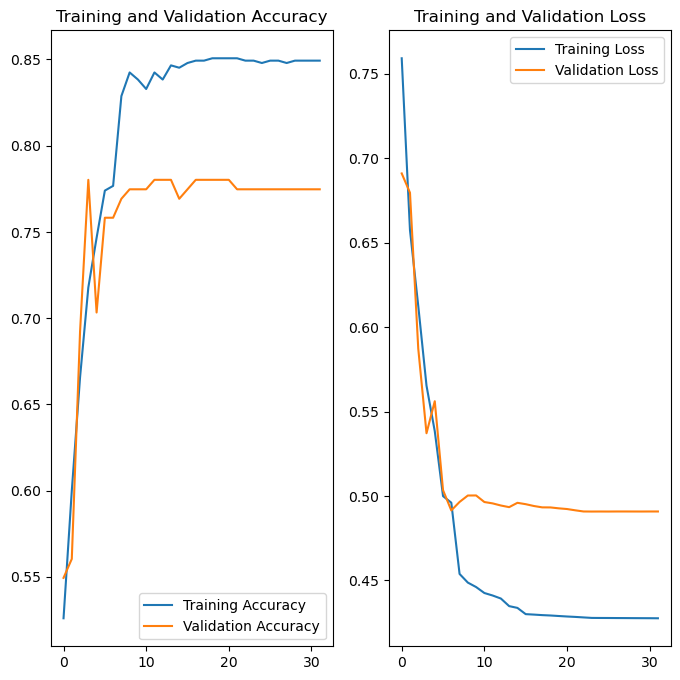

In [157]:
acc = fine_tuned_model.history['binary_accuracy']
val_acc = fine_tuned_model.history['val_binary_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()